# Milestone 3

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import *
from src.utilities.synonym_utils import add_new_synonyms
from src.utilities.utils import *
from src.utilities.plotting import *
from src.utilities.countries_utils import *
import math
import pygal
from pygal.style import Style
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Quotebank preprocessing

Most of the code used for the quotebank preprocessing can be found in the classes QuotebankData and Keyword, in addition to in files for helper functions. 

Initialize quotebank
- read keyword and synonyms for death causes
- create folders and file names for quotes that matches keywords or synonyms
- match keywords and synonyms with quotes

Since the last step takes a lot of time, we performed it separately in the file run_quotebank_search.py. In this notebook, we will load the results we got from there, to analyze those further.
run_quoteban_search.py matches quotes with certain topics with the help of synonyms, created with src/utilities/synonyms_utils.py. After keyword matching, seven topics are further filtered with clustering, which is performed with the help of src/utilities/clustering.py. The topics for clustering were determined based on random samples we took from found quotes.

load database of speakers


In [2]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()

In [3]:
import warnings
import collections

warnings.filterwarnings("ignore")

def save_meta_data_quotes():
    
    quotebank.quotes_occurrences_df = pd.DataFrame()
    for year in range(BEGIN_YEAR, END_YEAR + 1):
        print("Creating meta data for year:", year, "...")
        dict_df_row = {"Year": year}
        
        for key in quotebank.keywords:
            file = key.output_filenames[year-BEGIN_YEAR]
            with open(file, 'rU') as f:
                quotes = pd.read_json(file, lines=True)
                
            dict_df_row[key.name] = 0
            if len(quotes) <= 0: continue
                
            # Save total number of quotes per year per topic in df
            num_of_quotes = quotes["n_appearances"].sum()
            dict_df_row[key.name] = num_of_quotes

            for _, line_quotes in quotes.iterrows():
                # Safe number of quotes per topic per year per country of url
                country_urls = line_quotes['country_urls']
                for country in country_urls:
                    if country == "Great Britain":
                        country = "United Kingdom"
                    if (country, year) in key.country_url_occurences:
                        key.country_url_occurences[(country, year)] += 1
                    else:
                        key.country_url_occurences[(country, year)] = 1

                # Safe number of quotes per topic per year per country of speaker
                country_speaker = line_quotes['country_speaker']
                if country_speaker:
                    if isinstance(country_speaker, list):        # if multiple countries, take most occuring
                        country_speaker = collections.Counter(country_speaker).most_common(1)[0][0]

                    if (country_speaker,year) in key.country_speaker_occurences:
                        key.country_speaker_occurences[(country_speaker,year)] +=1
                    else:
                        key.country_speaker_occurences[(country_speaker,year)] = 1 
            
        quotebank.quotes_occurrences_df = quotebank.quotes_occurrences_df.append(dict_df_row, ignore_index = True)
        cols = quotebank.quotes_occurrences_df.columns
        quotebank.quotes_occurrences_df[cols] = quotebank.quotes_occurrences_df[cols].astype(int)

### Load the results of the quote finding

In [4]:
save_meta_data_quotes()

Creating meta data for year: 2008 ...
Creating meta data for year: 2009 ...
Creating meta data for year: 2010 ...
Creating meta data for year: 2011 ...
Creating meta data for year: 2012 ...
Creating meta data for year: 2013 ...
Creating meta data for year: 2014 ...
Creating meta data for year: 2015 ...
Creating meta data for year: 2016 ...


In [5]:
quotebank.quotes_occurrences_df

,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,Cirrhosis and other chronic liver diseases,Digestive diseases,...,Road injuries,Maternal disorders,Neonatal disorders,Exposure to forces of nature,Diarrheal diseases,Nutritional deficiencies,Suicide,War and terrorism,Diabetes mellitus,Poisonings
0,2008,64,521,863,4443,898,166,1059,323,96,...,5450,2105,77,18544,784,298,5170,26126,268,321
1,2009,601,2247,2218,15954,5710,866,4371,1885,713,...,24223,9339,302,92177,929,1192,18223,118306,1086,2789
2,2010,411,2386,3820,16459,7181,961,4636,1786,339,...,21684,9832,384,90977,2724,1746,17032,120538,1211,2664
3,2011,370,1980,1983,16454,6113,893,5058,2326,388,...,19750,11430,347,107521,1360,1711,15523,129636,967,1372
4,2012,625,2268,1791,16448,8138,882,4700,2498,579,...,33134,11786,409,123841,979,1366,15947,169723,1106,1601
5,2013,589,1864,1552,14816,6901,1111,4630,2371,714,...,20424,9812,292,74850,710,1516,13981,126723,1162,4011
6,2014,514,2390,1670,17079,8111,935,5390,2677,999,...,23257,11842,480,79026,750,1567,18049,203666,1151,2008
7,2015,687,2707,1839,17731,9571,1079,6547,3850,759,...,25836,13904,420,98010,900,1456,22176,261676,1253,2612
8,2016,534,2581,1785,13636,8027,1020,3811,2222,510,...,16891,8737,474,60966,1144,1136,17221,179159,1211,2050


In [6]:
quotebank.quotes_percentage_df = percentage_of_total_count(quotebank.quotes_occurrences_df, TOPICS)

In [7]:
quotebank.quotes_percentage_df

,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Cardiovascular diseases,Alzheimer disease and other dementias,Chronic kidney disease,Chronic respiratory diseases,Cirrhosis and other chronic liver diseases,Digestive diseases,...,Road injuries,Maternal disorders,Neonatal disorders,Exposure to forces of nature,Diarrheal diseases,Nutritional deficiencies,Suicide,War and terrorism,Diabetes mellitus,Poisonings
0,2008,0.067399,0.548669,0.908832,4.678960,0.945691,0.174816,1.115242,0.340154,0.101098,...,5.739440,2.216793,0.081089,19.528839,0.825637,0.313826,5.444570,27.513506,0.282233,0.338048
1,2009,0.142259,0.531872,0.525008,3.776363,1.351575,0.204985,1.034630,0.446186,0.168769,...,5.733662,2.210571,0.071484,21.818591,0.219897,0.282150,4.313442,28.003409,0.257060,0.660165
2,2010,0.096105,0.557925,0.893241,3.848654,1.679153,0.224713,1.084049,0.417625,0.079269,...,5.070430,2.299044,0.089792,21.273407,0.636961,0.408272,3.982640,28.185738,0.283172,0.622931
3,2011,0.082065,0.439159,0.439824,3.649454,1.355847,0.198065,1.121851,0.515901,0.086057,...,4.380498,2.535144,0.076964,23.847874,0.301644,0.379495,3.442960,28.752922,0.214478,0.304306
4,2012,0.111162,0.403385,0.318546,2.925431,1.447419,0.156872,0.835939,0.444293,0.102981,...,5.893192,2.096250,0.072744,22.026280,0.174124,0.242956,2.836323,30.186823,0.196712,0.284753
5,2013,0.143278,0.453429,0.377533,3.604077,1.678708,0.270257,1.126274,0.576759,0.173685,...,4.968255,2.386825,0.071031,18.207692,0.172712,0.368776,3.400958,30.826096,0.282663,0.975699
6,2014,0.097977,0.455572,0.318329,3.255530,1.546086,0.178226,1.027420,0.510279,0.190425,...,4.433156,2.257274,0.091496,15.063618,0.142962,0.298695,3.440428,38.821993,0.219399,0.382757
7,2015,0.106355,0.419073,0.284697,2.744954,1.481696,0.167041,1.013548,0.596022,0.117502,...,3.999697,2.152492,0.065021,15.173024,0.139330,0.225405,3.433088,40.510319,0.193978,0.404366
8,2016,0.123731,0.598032,0.413595,3.159539,1.859901,0.236340,0.883030,0.514850,0.118170,...,3.913741,2.024413,0.109828,14.126168,0.265071,0.263218,3.990203,41.512158,0.280596,0.474997


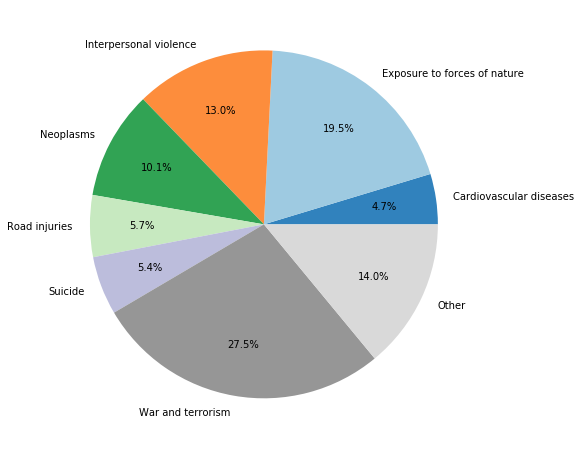

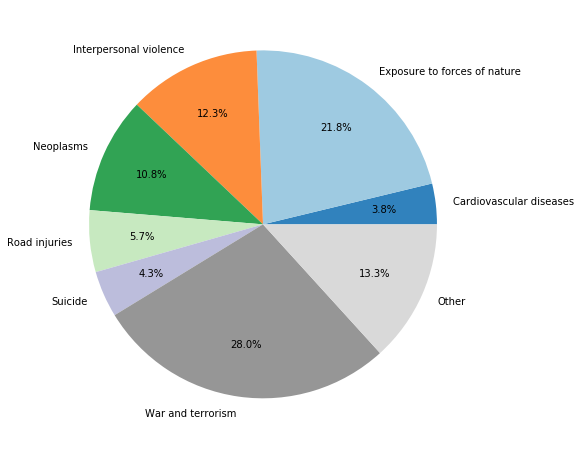

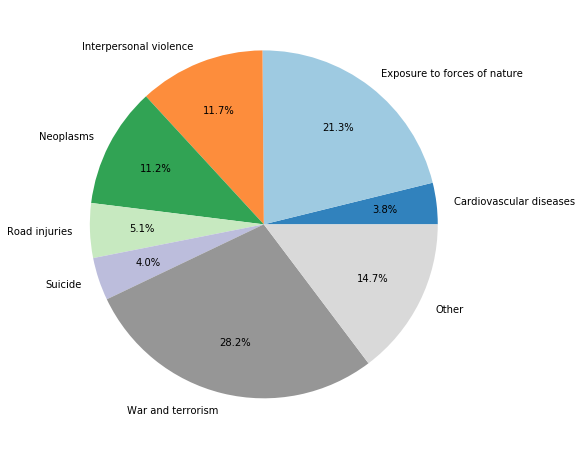

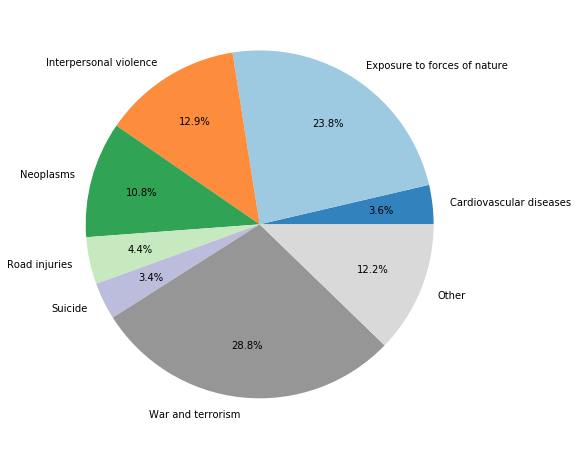

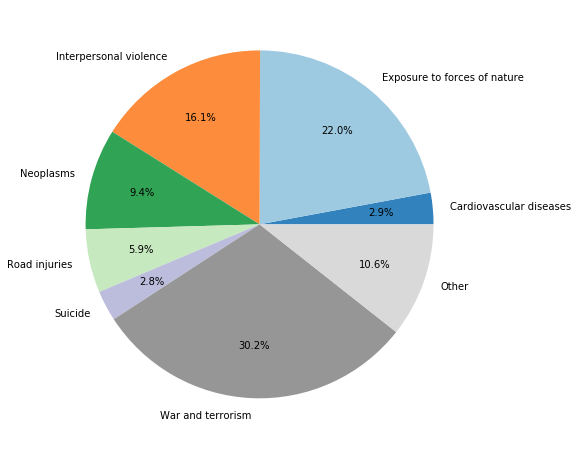

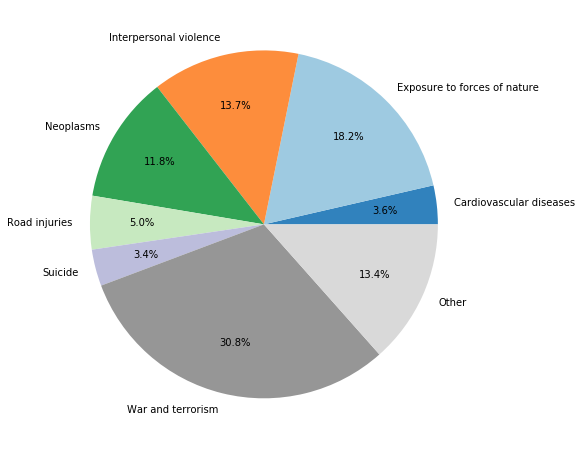

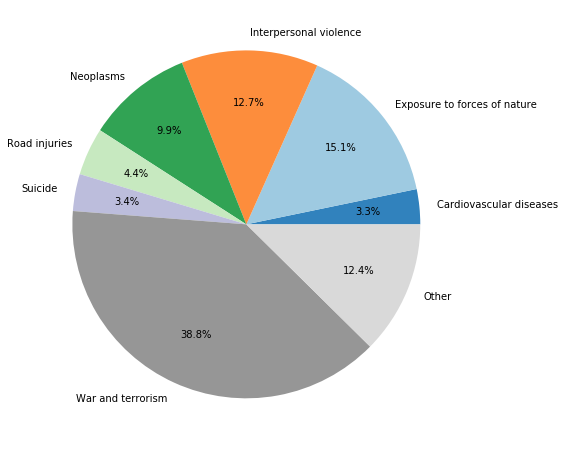

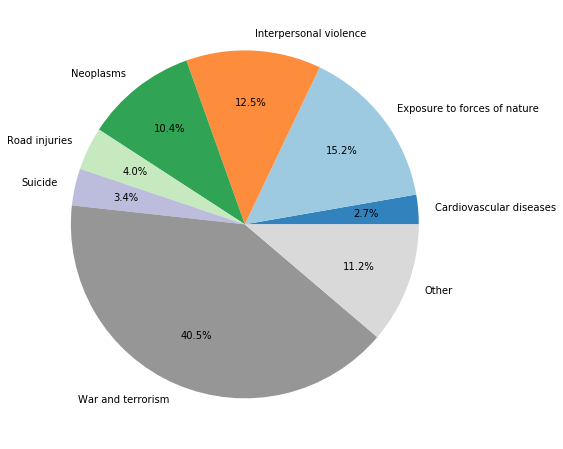

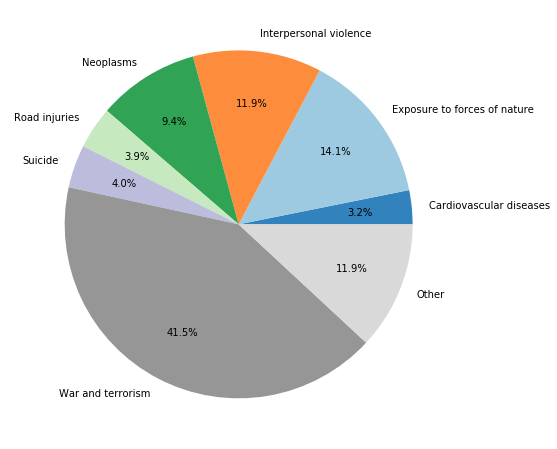

In [8]:
for y in range(BEGIN_YEAR, END_YEAR + 1):
    cause_pie_chart_plot(quotebank.quotes_percentage_df, y, 7, "_quotes_")

In [9]:
quotebank.map_df_causes_to_categories()

In [10]:
quotebank.cat_quotes_occurrences_df

,Year,Injuries,Non-communicable diseases,Communicable diseases
0,2008,69434.0,17108.0,8415.0
1,2009,312619.0,77743.0,32108.0
2,2010,312541.0,81783.0,33332.0
3,2011,336676.0,83261.0,30925.0
4,2012,442479.0,89256.0,30507.0
5,2013,302884.0,82667.0,25539.0
6,2014,400922.0,91190.0,32503.0
7,2015,501442.0,110174.0,34333.0
8,2016,334247.0,72860.0,24475.0


In [11]:
quotebank.cat_quotes_percentage_df = percentage_of_total_count(quotebank.cat_quotes_occurrences_df, CATEGORIES)

In [12]:
quotebank.cat_quotes_percentage_df

,Year,Injuries,Non-communicable diseases,Communicable diseases
0,2008,73.121518,18.016576,8.861906
1,2009,73.997917,18.402017,7.600066
2,2010,73.082337,19.123548,7.794115
3,2011,74.673847,18.467070,6.859083
4,2012,78.699030,15.875015,5.425955
5,2013,73.678270,20.109222,6.212508
6,2014,76.422138,17.382271,6.195591
7,2015,77.628729,17.056145,5.315125
8,2016,77.446928,16.882076,5.670996


# Country preprocessing

#### first find for how many quotes we actually found the country (w.r.t. url and speaker)

In [13]:
num_url_country = 0
num_speaker_country = 0
for i in range(len(quotebank.keywords)):   
    for key in quotebank.keywords[i].country_url_occurences:
        num_url_country += quotebank.keywords[i].country_url_occurences[key]
    for key in quotebank.keywords[i].country_speaker_occurences:
        num_speaker_country += quotebank.keywords[i].country_speaker_occurences[key]
        
total_quotes = quotebank.quotes_occurrences_df.sum().sum()
print("Percentage of country of url found: {:.4f}".format(num_url_country/total_quotes))
print("Percentage of country of speaker found: {:.4f}".format(num_speaker_country/total_quotes))

Percentage of country of url found: 0.9955
Percentage of country of speaker found: 0.2737


#### Create maps to show where the most quotes are from.

In [ ]:
# Create Maps for all years for speaker and url and safes them in data/images/year_(url/speaker)_country_occurences.svg
url_speaker = ["url","speaker"]
for target in url_speaker:
    for year in range(2008,2017):
        totals_per_country = quotebank.get_quote_occurences_per_country_year(target)
        mapping = map_countries_according_to_mag_order(totals_per_country, year)
        create_world_map(mapping, str(year) + "_" + target + "_country_occurences", year)

#### Show the distribution of topics for the quotes in certain countries where enough quotes were found



First for url

In [ ]:

countries = ['United Kingdom', 'United States of America','Canada', 'Australia', 'India', 'Pakistan', 'France','South Africa']
for year in range(2008,2017):
    if year == 2008:
        totals_per_country = quotebank.get_country_per_year_count('url', countries, year)
    else:
        totals_per_country = totals_per_country + quotebank.get_country_per_year_count('url', countries, year)
        
df_reduce = reduce_df(totals_per_country, 5, return_percentage = True)
countries.append('Rest of the World')
stacked_barplot(df_reduce, x_labels=countries, y_label= "Percentage", title=None,
                width = 0.35, safe_name='country_specific_quote_url_percentage', log_y=False)

In [ ]:
df_reduce = reduce_df(totals_per_country, 5, return_percentage = False)
countries.append('Rest of the World')
stacked_barplot(df_reduce, x_labels=countries, y_label= "Occurences (log)", title=None,
                width = 0.35, safe_name='country_specific_quote_url_log', log_y=True)

Now for the speaker

In [ ]:
countries = ['United Kingdom', 'United States of America','Canada', 'Australia', 'India', 'Pakistan', 'France','South Africa']
for year in range(2008,2017):
    if year == 2008:
        totals_per_country = quotebank.get_country_per_year_count('speaker', countries, year)
    else:
        totals_per_country = totals_per_country + quotebank.get_country_per_year_count('speaker', countries, year)
        
df_reduce = reduce_df(totals_per_country, 5, return_percentage = True)
countries.append('Rest of the World')
stacked_barplot(df_reduce, x_labels=countries, y_label= "Percentage", title=None,
                width = 0.35, safe_name='country_specific_quote_speaker_percentage', log_y=False)

In [ ]:
df_reduce = reduce_df(totals_per_country, 5, return_percentage = False)
countries.append('Rest of the World')
stacked_barplot(df_reduce, x_labels=countries, y_label= "Occurences (log)", title=None,
                width = 0.35, safe_name='country_specific_quote_speaker_log', log_y=True)

## Show real death causes for regions in the world

In [ ]:
# Will print Nan if values are missing. If possible, the values will be replaced by learning them with linear regression
deaths = dict()
for region in REGIONS:
    df = Deaths("deaths_by_cause", region, DEATH_BY_CAUSE_PATH, rename_cols = RENAME_CAUSE_COLS, drop_cols = DROP_CAUSE_COLS).df
    for main_region in MAIN_REGIONS:
        if region in MAIN_REGIONS[main_region]:
            if main_region in deaths:
                deaths[main_region] += df.fillna(0)
                deaths[main_region]["Year"] = deaths[main_region]["Year"]/2
            else:
                deaths[main_region] = df.fillna(0)

In [ ]:
# Sum causes for all years together
for year in range(2008,2016):
    deaths_year, _, labels = get_data_for_one_year(deaths, year)
    if year == 2008:
        all_deaths = deaths_year
    else:
        all_deaths = all_deaths + deaths_year
# plot relative number of deaths
all_deaths_reduced = reduce_df(all_deaths, percentage_treshold = 5, return_percentage = True)
stacked_barplot(all_deaths_reduced, x_labels = labels,
                y_label= "Percentage", safe_name="deaths_world_regions", log_y=False)

# plot absolute number of deaths
all_deaths_reduced = reduce_df(all_deaths, percentage_treshold = 5, return_percentage = False)
stacked_barplot(all_deaths_reduced, x_labels = labels,
                y_label="Occurences (log)", safe_name="absolute_deaths_world_regions", log_y=True)

# Our World in Data preprocessing

### Deaths by cause

In [ ]:
death_by_cause_path = DATA_PATH + "annual_number_of_deaths_by_cause.csv"
deaths_by_cause = Deaths("deaths_by_cause", "World", death_by_cause_path, rename_cols = RENAME_CAUSE_COLS, drop_cols = DROP_CAUSE_COLS)
deaths_by_cause.df

In [ ]:
deaths_by_cause.percentage_df

### Deaths by category

In [ ]:
death_by_category_path = DATA_PATH + "categorized_annual_number_of_deaths.csv"
deaths_by_category = Deaths("deaths_by_category",'World', death_by_category_path, rename_cols = RENAME_CAT_COLS)
deaths_by_category.df

In [ ]:
deaths_by_category.percentage_df

## Plotting

### Deaths by cause

In [ ]:
deaths_by_cause.plot_stacked_areas()

In [ ]:
for y in range(2008, 2017):
    cause_pie_chart_plot(deaths_by_cause.percentage_df, y, 7, "_death_")

### Deaths by category

In [ ]:
deaths_by_category.plot_stacked_areas()

# RQ1

In [ ]:
def get_summed_values(df, cols):
    values = []
    for col in cols:
        values.append(df[col].sum())
    return np.array(values)


def create_RQ1_df():
    causes = deaths_by_cause.quant_columns
    
    summed_death_values = get_summed_values(deaths_by_cause.df, causes)
    summed_quote_values = get_summed_values(quotebank.quotes_occurrences_df, causes)
    
    quotes_per_death = np.divide(summed_quote_values, summed_death_values/1000000)
    
    df = pd.DataFrame(columns=causes)

    for i, cause in enumerate(causes):
        df.at[0, cause] = quotes_per_death[i]
    
    return df


def plot_RQ1(log = True):
    
    df = create_RQ1_df()

    df = df.T
    value_col = list(df.columns)[0]
    df = df.sort_values([value_col], ascending=False)
    
    ax = plt.gca()
    df.plot.barh(figsize=(12,12), log=log, title=None, ax=ax, xlabel=None, ylabel=None, color="#006198", legend=None, xlim = (10**2,10**6))
    
    # Remove border top and right
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    
    # Remove y Ticks
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.6,
            alpha = 0.2)
        
    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.4,
                 ' ' + pretty_num_string(int(i.get_width())),
                 fontsize = 10, fontweight ='bold',
                 color ="#777777")
        
    save_plt("quotes_per_million_deaths")
    plt.show()    

In [ ]:
plot_RQ1()

# RQ2

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
COLORS = ["003F5C", "2F4B7C", "665191", "A05195", "D45087", "F95D6A", "FF7C43", "FF600"]
COLOR_MAP = plt.get_cmap('tab20c')

def plot_actual_vs_quote_per_year(d_c_actual, df_a, df_q, x_label, y_label_1, y_label_2, year_list = list(range(BEGIN_YEAR, END_YEAR +1))):
    
    quote_occurences = list()
    actual_occurences = list()
    
    for year in year_list:
        quote_occurences.append(df_q.loc[df_q['Year'] == year][d_c_actual].values)
        actual_occurences.append(df_a.loc[df_a['Year'] == year][d_c_actual].values)
        
    host = host_subplot(111)
    par = host.twinx()

    host.set_xlabel(x_label)
    host.set_ylabel(y_label_1)
    par.set_ylabel(y_label_2)

    p1, = host.plot(year_list, quote_occurences, label=y_label_1)
    p2, = par.plot(year_list, actual_occurences, label=y_label_2)

    leg = plt.legend()

    host.yaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.yaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    
    plt.xticks(year_list)
    plt.savefig('./generated/images/double_line_' + d_c_actual.replace("/", "_") + '.png') 
    plt.show()


In [ ]:
for cause in TOPICS:
    print(cause)
    plot_actual_vs_quote_per_year(cause, deaths_by_cause.percentage_df, quotebank.quotes_percentage_df,
    "Year", "Quotebank", "Actual deaths")

In [ ]:
for category in CATEGORIES:
    plot_actual_vs_quote_per_year(category, deaths_by_category.percentage_df, quotebank.cat_quotes_percentage_df,
        "Year", "Quotebank", "Actual deaths")

# RQ5

In [ ]:
def plot_RQ5():
    index = ["Quotes", "Deaths"]
    width = 0.4
    
    value_dict = {}

    for column in deaths_by_category.quant_columns:
        value_dict[column] = [quotebank.cat_quotes_percentage_df[column].sum(), 
                  deaths_by_category.percentage_df[column].sum()]


    df = pd.DataFrame({INJURIES: value_dict[INJURIES], 
                       NON_COMMUNICABLE_DISEASES: value_dict[NON_COMMUNICABLE_DISEASES], 
                       COMMUNICABLE_DISEASES: value_dict[COMMUNICABLE_DISEASES]}, 
                       index=index)
    df = percentage_of_total_count(df, CATEGORIES)

    ax = df.plot.bar(stacked=True, colormap=COLOR_MAP)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_ylabel('')
    
    save_plt("RQ5")

    plt.show()

In [ ]:
plot_RQ5()